# Colab Setup

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLVU/HW3'

/content/drive/MyDrive/MLVU/HW3


## Module Import

In [12]:
!pip install xmltodict
!pip install pycocotools

In [14]:
import numpy as np
import os
import cv2
import xmltodict
import numpy
import math

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Input, Concatenate, ReLU
from tensorflow.keras.models import Model

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import scipy
import skimage.io
from skimage.segmentation import find_boundaries


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Global Parameters

In [15]:
data_path = '/content/drive/MyDrive/MLVU/HW3/coco'
ckpt_path = './ckpt/'

image_size = 128
min_dim = 100
max_obj_num = 100

unet_base_filters = 64
in_channels = 3

w0 = 10
sigma = 5

batch_size = 16
learning_rate = 1e-4
num_epochs = 4

## [0] Data Loading

In [16]:
class Dataset(object):
    """
    The base class for dataset classes.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                return
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        
        return ""

    def prepare(self, class_map=None):
        """
        Prepares the Dataset class for use.
        """

        def clean_name(name):
            """
            Returns a shorter version of object names for cleaner display.
            """
            return ",".join(name.split(",")[:1])

        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}
        self.image_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.image_info, self.image_ids)}

        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}

        for source in self.sources:
            self.source_class_ids[source] = []

            for i, info in enumerate(self.class_info):
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """
        Takes a source class ID and returns the int class ID assigned to it.
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """
        Map an internal class ID to the corresponding class ID in the source dataset.
        """
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """
        Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        image = skimage.io.imread(self.image_info[image_id]['path'])
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)

        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_id):
        """
        Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        """
        logging.warning("You are using the default load_mask(), maybe you need to define your own one.")
        mask = np.empty([0, 0, 0])
        class_ids = np.empty([0], np.int32)
        return mask, class_ids

In [17]:
class CocoDataset(Dataset):
    def load_coco(self, dataset_dir, subset, year=2017, class_ids=None,
                  class_map=None, return_coco=False):
        """
        Load a subset of the COCO dataset.
        
        Inputs:
        - dataset_dir: The root directory of the COCO dataset.
        - subset: What to load (train, val, minival, valminusminival)
        - year: What dataset year to load (2014, 2017)
        - class_ids: If provided, only loads images that have the given classes.
        - class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        - return_coco: If True, returns the COCO object.
        """

        
        coco = COCO("{}/annotations/instances_{}{}.json".format(dataset_dir, subset, year))
        if subset == "minival" or subset == "valminusminival":
            subset = "val"
        image_dir = "{}/{}{}".format(dataset_dir, subset, year)

        if not class_ids:
            class_ids = sorted(coco.getCatIds())

        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            image_ids = list(set(image_ids))
        else:
            image_ids = list(coco.imgs.keys())

        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_coco:
            return coco

    def load_mask(self, image_id):
        """
        Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        
        Returns:
        - masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        - class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]

        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])

                if m.max() < 1:
                    continue

                if annotation['iscrowd']:

                    class_id *= -1

                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)


        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:

            return super(CocoDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        """
        Return a link to the image in the COCO Website.
        """
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(CocoDataset, self).image_reference(image_id)

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [18]:
def resize_image(image, min_dim=None, max_dim=None, min_scale=None):
    """
    Resizes an image keeping the aspect ratio unchanged.
    
    Inputs:
    - min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    - max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    - min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
        
    Returns:
    - image: the resized image
    - scale: The scale factor used to resize the image
    - padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """

    image_dtype = image.dtype

    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]


    ## Scale Adjustment
    if min_dim:
        scale = max(1, min_dim / min(h, w))

    if min_scale and scale < min_scale:
        scale = min_scale

    if max_dim:
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    ## Image Scaling
    if scale != 1:
        image = cv2.resize(image, (round(w * scale), round(h * scale)))

    ## Padding
    h, w = image.shape[:2]
    top_pad = (max_dim - h) // 2
    bottom_pad = max_dim - h - top_pad
    left_pad = (max_dim - w) // 2
    right_pad = max_dim - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)
    window = (top_pad, left_pad, h + top_pad, w + left_pad)

    return image.astype(image_dtype), scale, padding


def resize_mask(mask, scale, padding):
    """
    Resizes a mask using the given scale and padding.
    """
    mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    mask = np.pad(mask, padding, mode='constant', constant_values=0)

    return mask

In [19]:
def load_image_gt(dataset, image_id):
    """
    Load and return ground truth data for an image (image, mask, bounding boxes).
    
    Inputs:
    - dataset
    - image_id
    
    Returns:
    - image: [height, width, 3]
    - class_ids: [instance_count] Integer class IDs
    - mask: [height, width, instance_count]

    """
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

    image, scale, padding = resize_image(
        image,
        min_dim=min_dim,
        min_scale=0,
        max_dim=image_size)
    mask = resize_mask(mask, scale, padding)


    ## correction for label error occurred by resizing
    _idxs = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idxs]
    class_ids = class_ids[_idxs]

    return image, class_ids, mask

### (Data Generator for Training)

In [20]:
def data_generator(dataset, shuffle=True, batch_size=1):
    """
    A generator that returns images and corresponding target class ids, and masks.
    
    Inputs:
    - dataset: The Dataset object to pick data from
    - shuffle: If True, shuffles the samples before every epoch
    - batch_size: How many images to return in each call
    
    Outputs:
    - images: [batch, H, W, C]
    - gt_class_ids: [batch, max_obj_num] Integer class IDs
    - gt_masks: [batch, height, width, max_obj_num]
    
    """
    
    b = 0  
    image_index = -1
    image_ids = np.copy(dataset.image_ids)


    while(True):
        image_index = (image_index + 1) % len(image_ids)
        if shuffle and image_index == 0:
            np.random.shuffle(image_ids)


        image_id = image_ids[image_index]

        image, gt_class_ids, gt_masks = load_image_gt(dataset, image_id)


        if not np.any(gt_class_ids > 0):
            continue

        if b == 0:
            batch_images = np.zeros(
                (batch_size,) + image.shape, dtype=np.float32)
            batch_gt_class_ids = np.zeros(
                (batch_size, max_obj_num), dtype=np.int32)
            batch_gt_masks = np.zeros(
                (batch_size, gt_masks.shape[0], gt_masks.shape[1],
                 max_obj_num), dtype=gt_masks.dtype)

        if gt_masks.shape[-1] > max_obj_num:
            ids = np.random.choice(
                np.arange(gt_masks.shape[-1]), max_obj_num, replace=False)
            gt_class_ids = gt_class_ids[ids]
            gt_masks = gt_masks[:, :, ids]

        batch_images[b] = image.astype(np.float32)
        batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
        batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks

        b += 1

        if b >= batch_size:
            outputs = [batch_images, batch_gt_class_ids, batch_gt_masks]

            yield outputs

            b = 0

### (Print Dataset Sample)

In [21]:
dataset_train = CocoDataset()
dataset_train.load_coco(data_path, "train", year=2017)
dataset_train.prepare()

class_names = dataset_train.class_names
num_classes = len(class_names)

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!


In [22]:
_train_generator = data_generator(dataset_train, shuffle=True, batch_size=batch_size)

In [23]:
sample = next(_train_generator)

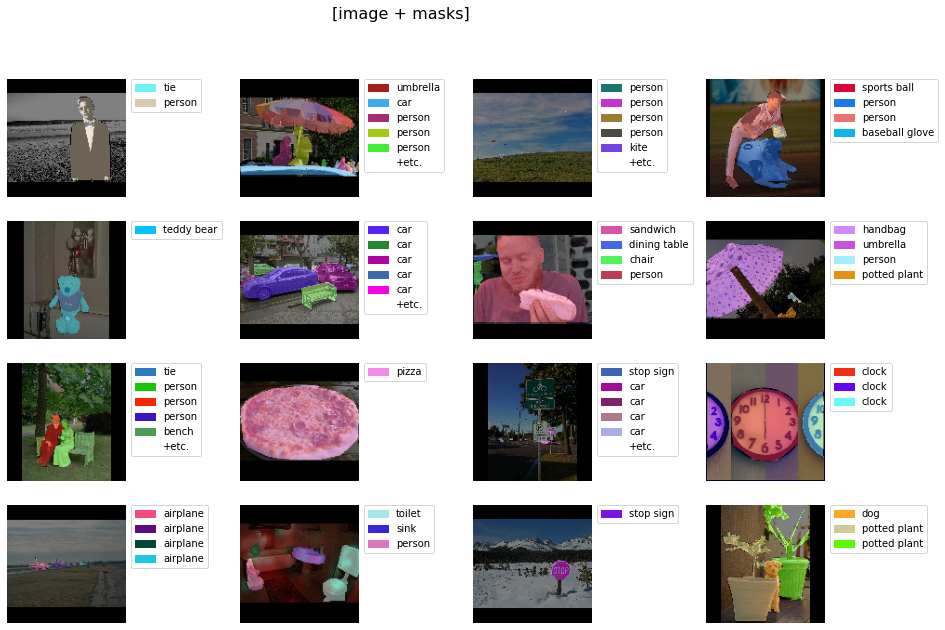

In [24]:
ncols = 4
nrows = math.ceil(batch_size/4)

max_legend = 6


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10))
axes = axes.ravel()


for idx in range(batch_size):
    ax = axes[idx]
    
    ax.imshow(sample[0][idx]/255.)


    mask = np.zeros(sample[-1][idx].shape[:2] + (4,), dtype=np.float32)
    patches = []

    for i in range(sample[-1][idx].shape[-1]):
      temp = np.repeat(np.expand_dims(sample[-1][idx][:,:,i].astype(np.float32), -1), 4, -1)
      temp[:,:,-1] = (temp[:,:,0]==1.).astype(np.float32)

      if sample[1][idx][i] != 0:
        c = np.random.rand(3)
        c = np.append(c, 1.)

        mask += (temp * c)
        
        if len(patches) == max_legend-1:
            patches.append(mpatches.Patch(color=[1.]*3, label='+etc.'))
        else: 
            patches.append(mpatches.Patch(color=c[:3], label=class_names[sample[1][idx][i]]))


    ax.imshow(np.minimum(1.,mask[:,:,:3]), alpha=0.5)
    ax.legend(handles=patches[:max_legend], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    ax.axis('off')
    
    
for idx in range(batch_size, nrows*ncols):
    fig.delaxes(axes[idx])

    
fig.suptitle('[image + masks]', size=16)
plt.show()

## [1] Model

In [25]:
class BasicConv(Layer):
    """
    Building block for the 2 times 3x3 conv in UNET.
    
    """

    def __init__(self, nr_filters, act_fn):
        super(BasicConv, self).__init__()
        self.conv1 = Conv2D(filters=nr_filters, kernel_size=(3,3), padding="same")
        self.BN1 = BatchNormalization()
        self.act = Activation(act_fn)
        self.conv2 = Conv2D(filters=nr_filters, kernel_size=(3,3), padding="same")
        self.BN2 = BatchNormalization()
        
    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.BN1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = self.act(x)
        
        return x

class UNet(Model):
    def __init__(self, num_filter, act_fn, out_channel, out_act_fn="softmax", pad=None):
        super(UNet, self).__init__()

        ### Q1. (b) ###
        """
        Declare layers as class's internal variables

        **Locate Batch_Normalization layer right after every 3x3 conv layer and before activation. (i.e. 3x3 Conv -> Batch Norm -> ReLU)
        """

        self.conv1 = BasicConv(num_filter, act_fn)
        self.pool = MaxPool2D(pool_size=(2,2), strides=(2,2))
        self.conv2 = BasicConv(num_filter*2, act_fn)
        self.conv3 = BasicConv(num_filter*4, act_fn)
        self.conv4 = BasicConv(num_filter*8, act_fn)
        self.conv5 = BasicConv(num_filter*16, act_fn)
        self.tconv1 = Conv2DTranspose(num_filter*8, (2,2), strides=(2,2))
        self.concat = Concatenate()
        self.conv6 = BasicConv(num_filter*8, act_fn)
        self.tconv2 = Conv2DTranspose(num_filter*4, (2,2), strides=(2,2))
        self.conv7 = BasicConv(num_filter*4, act_fn)
        self.tconv3 = Conv2DTranspose(num_filter*2, (2,2), strides=(2,2))
        self.conv8 = BasicConv(num_filter*2, act_fn)
        self.tconv4 = Conv2DTranspose(num_filter, (2,2), strides=(2,2))
        self.conv9 = BasicConv(num_filter, act_fn)
        self.conv10 = Conv2D(filters=out_channel, kernel_size=(1,1), padding="same")
        self.out_act = Activation(out_act_fn)
        ### Q1. (b) ###


    def call(self, x, training=None):

        ### Q1. (b) ###
        """
        Complete call function using declared layers
        """

        x = self.conv1(x)
        FirstSkip = x
        x1 = self.pool(x)
        x1 = self.conv2(x1)
        SecondSkip = x1
        x2 = self.pool(x1)
        x2 = self.conv3(x2)
        ThirdSkip = x2
        x3 = self.pool(x2)
        x3 = self.conv4(x3)
        FourthSkip = x3
        x4 = self.pool(x3)
        x4 = self.conv5(x4)
        x4 = self.tconv1(x4)
        x4 = self.concat([FourthSkip,x4])
        x4 = self.conv6(x4)
        x4 = self.tconv2(x4)
        x4 = self.concat([ThirdSkip,x4])
        x4 = self.conv7(x4)
        x4 = self.tconv3(x4)
        x4 = self.concat([SecondSkip,x4])
        x4 = self.conv8(x4)
        x4 = self.tconv4(x4)
        x4 = self.concat([FirstSkip,x4])
        x4 = self.conv9(x4)
        x4 = self.conv10(x4)
        x4 = self.out_act(x4)
        ### Q1. (b) ###
        return x4


    def compile(self, optimizer, loss_fn):
        super().compile(optimizer)
        self.loss_fn = loss_fn


    def train_step(self, inputs, training=True):
        with tf.GradientTape() as tape:
            y_pred = self.call(inputs[0], training=True)
            train_loss = self.loss_fn(inputs, y_pred)
        
        grads = tape.gradient(train_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return train_loss, y_pred

## [2] Loss & Metric Function

### (Loss)

In [26]:
def weight_map_for_loss(inputs):
    """
    inputs : [images, class_labels, segmentation_labels]
      ; images (batch_size, image_size, image_size, max_obj_num)
      ; class_labels (batch_size, num_classes)
      ; segmentation_labels (batch_size, image_size, image_size, max_obj_num)
    outputs : output of model(UNet)
      ; (batch_size, image_size, image_size, num_classes)

    """
    B,H,W = inputs[-1].shape[:3]
    border_weight_map = np.zeros((B,H,W))
    class_weight_map = np.zeros((B,H,W))
    
    ### Q1.(c) ###
    """
    border_weight_map calculation
    (Note. Vectorization is very essential)
    
    """
    sigmasq = 5**2
    w0 = 10
    border_weight_map_tmp = np.zeros((B,H,W,inputs[-1].shape[3]))
    sigmasq = 5**2
    w0 = 10
    for img in range(B):
      for ins in range(inputs[-1].shape[3]):
        border_weight_map_tmp[img,:,:,ins] = cv2.distanceTransform(np.logical_not(find_boundaries(inputs[-1][img,:,:,ins])).astype(np.uint8), distanceType=cv2.DIST_L2, maskSize=0)
      tmp = np.partition(border_weight_map_tmp[img,:,:,:],2,axis=2)
      border_weight_map[img,:,:]=w0*np.exp(-(tmp[:,:,0]+tmp[:,:,1])**2/(2*sigmasq))       
    
    ### Q1.(c) ###

        
    w_1 = 1 - inputs[-1].sum()/(B*H*W)
    w_0 = 1 - w_1

    class_weight_map[inputs[-1].sum(axis=-1) > 0] = w_1
    class_weight_map[inputs[-1].sum(axis=-1) == 0] = w_0 
    
    
    return border_weight_map + class_weight_map

In [27]:
def unet_loss(inputs, y_pred):
    #w = np.expand_dims(weight_map_for_loss(inputs), -1)
    w = weight_map_for_loss(inputs)
    ### Q2.(d) ###
    B,H,W = inputs[-1].shape[:3]
    gt_class = np.zeros((B,W,H,2))

    for batch in range(B):
        for i, cls in enumerate(inputs[1][batch]):
            if cls >= 1:
                gt_class[batch,:,:,1] += inputs[-1][batch,:,:,i]
            
    gt_class[:,:,:,1] = gt_class[:,:,:,1] > 0
    gt_class[:,:,:,0] = (gt_class[:,:,:,1] == 0)
    tmp = -w*tf.math.log(tf.math.reduce_sum(gt_class*y_pred,-1))
    loss = tf.math.reduce_mean(tmp)
    ### Q2.(d) ###
    
    return loss

#### (Print Weight Map of Sample Data)

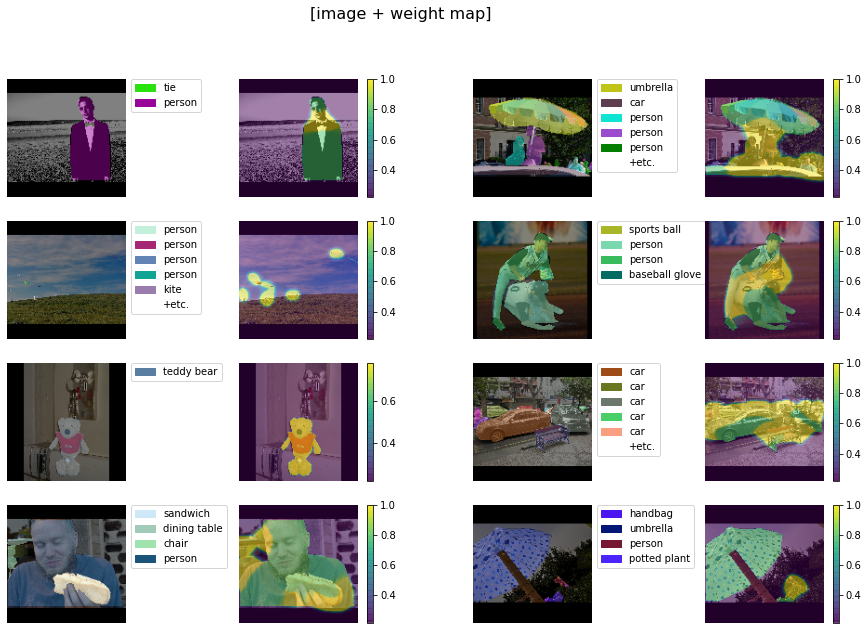

In [28]:
wm = weight_map_for_loss(sample)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10))
axes = axes.ravel()


for idx in range(int(batch_size//2)):
        ### Print image + mask
        ax = axes[2*idx]
    
        ax.imshow(sample[0][idx]/255.)


        mask = np.zeros(sample[-1][idx].shape[:2] + (4,), dtype=np.float32)
        patches = []

        for i in range(sample[-1][idx].shape[-1]):
          temp = np.repeat(np.expand_dims(sample[-1][idx][:,:,i].astype(np.float32), -1), 4, -1)
          temp[:,:,-1] = (temp[:,:,0]==1.).astype(np.float32)

          if sample[1][idx][i] != 0:
            c = np.random.rand(3)
            c = np.append(c, 1.)

            mask += (temp * c)

            if len(patches) == max_legend-1:
                patches.append(mpatches.Patch(color=[1.]*3, label='+etc.'))
            else: 
                patches.append(mpatches.Patch(color=c[:3], label=class_names[sample[1][idx][i]]))


        ax.imshow(np.minimum(1.,mask[:,:,:3]), alpha=0.5)
        ax.legend(handles=patches[:max_legend], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        ax.axis('off')
    
    
        ### Print weight map
        ax = axes[2*idx+1]

        ax.imshow(sample[0][idx]/255.)


        pos = ax.imshow(np.minimum(1.,wm[idx]), alpha=0.5)
        _ = fig.colorbar(pos, ax=ax)
        ax.axis('off')
        

        
for idx in range(2*int(batch_size/2), nrows*ncols):
        fig.delaxes(axes[idx])


fig.suptitle('[image + weight map]', size=16)
plt.show()


### (Metric)

In [29]:
def accuracy(inputs, y_pred):
    
    y_pred_binary = (y_pred == np.max(y_pred, -1, keepdims=True))
    
    
    B, H, W, C = y_pred_binary.shape
    gt_class = np.zeros(y_pred_binary.shape)

    for batch in range(B):
        for i, cls in enumerate(inputs[1][batch]):
            if cls >= 1:
                gt_class[batch,:,:,1] += inputs[-1][batch,:,:,i]
            
    gt_class[:,:,:,1] = gt_class[:,:,:,1] > 0
    gt_class[:,:,:,0] = (gt_class[:,:,:,1] == 0)
    
    
    m_pred = np.copy(y_pred_binary).reshape(B, H*W, C)
    m_gt = np.copy(gt_class).reshape(B, H*W, C)    
    
    confusion_mat = np.zeros((C,C))
    
    for b in range(B):
        confusion_mat += (m_pred[b].T @ m_gt[b])
        
    accuracy = np.diag(confusion_mat).sum() / confusion_mat.sum()
    
    return accuracy

## [3] Main

In [30]:
dataset_train = CocoDataset()
dataset_train.load_coco(data_path, "train", year=2017)
dataset_train.prepare()


dataset_val = CocoDataset()
dataset_val.load_coco(data_path, "val", year=2017)
dataset_val.prepare()


class_names = dataset_train.class_names
num_classes = len(class_names)


train_generator = data_generator(dataset_train, shuffle=True, batch_size=batch_size)
val_generator = data_generator(dataset_val, shuffle=True, batch_size=batch_size)

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [31]:
unet = UNet(num_filter=unet_base_filters, act_fn="relu", out_channel=2, out_act_fn="softmax")

In [32]:
unet.build((None,image_size,image_size,in_channels))
unet.call(Input((image_size,image_size,in_channels)))
unet.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 basic_conv (BasicConv)      (None, 128, 128, 64)      39232     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 basic_conv_1 (BasicConv)    (None, 64, 64, 128)       222464    
                                                                 
 basic_conv_2 (BasicConv)    (None, 32, 32, 256)       887296    
                                                                 
 basic_conv_3 (BasicConv)    (None, 16, 16, 512)       3544064   
                                                                 
 basic_conv_4 (BasicConv)    (None, 8, 8, 1024)        14166016  
                                                             

In [33]:
unet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), loss_fn=unet_loss)

In [34]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.Mean(name='train_acc')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_acc = tf.keras.metrics.Mean(name='val_acc')


for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    for i, batch_input in enumerate(train_generator):

        loss, pred = unet.train_step(batch_input, training=True)
        train_loss(loss)
        
        acc = accuracy(batch_input, pred)
        train_acc(acc)
        

        if (i+1) % 50 == 0:
            print("\tProgress {:.0%} / Loss: {:.5f} / Acc.: {:.3f}".format(i/(len(dataset_train.image_ids)/batch_size), train_loss.result(), train_acc.result()))
                
        if i >= (len(dataset_train.image_ids)/batch_size)-1:
            break

    print("Epoch: {}, Loss: {:.5f}, Acc.: {:.3f}".format(epoch+1, train_loss.result(), train_acc.result()))
    
    train_loss.reset_states()
    train_acc.reset_states()
    

    for i, batch_input in enumerate(val_generator):

        loss, pred = unet.train_step(batch_input, training=False)
        val_loss(loss)

        acc = accuracy(batch_input, pred)
        val_acc(acc)

        if i >= (len(dataset_val.image_ids)/batch_size)-1:
            break

    print("Epoch: {}, Validation: Loss: {:.5f}, Acc.: {:.3f}".format(epoch+1, val_loss.result(), val_acc.result()))

    val_loss.reset_states()
    val_acc.reset_states()

    
    unet.save_weights('./ckpt/my_checkpoint_{}_{}of{}'.format(1, epoch+1, num_epochs))

Epoch 1/4
	Progress 10% / Loss: 0.80994 / Acc.: 0.626
	Progress 20% / Loss: 0.72234 / Acc.: 0.644
	Progress 30% / Loss: 0.68452 / Acc.: 0.648
	Progress 40% / Loss: 0.67587 / Acc.: 0.651
	Progress 50% / Loss: 0.65248 / Acc.: 0.657
	Progress 60% / Loss: 0.63867 / Acc.: 0.660
	Progress 70% / Loss: 0.63377 / Acc.: 0.660
	Progress 80% / Loss: 0.62692 / Acc.: 0.664
	Progress 90% / Loss: 0.62172 / Acc.: 0.666
	Progress 100% / Loss: 0.61679 / Acc.: 0.667
Epoch: 1, Loss: 0.61679, Acc.: 0.667
Epoch: 1, Validation: Loss: 0.59128, Acc.: 0.685
Epoch 2/4
	Progress 10% / Loss: 0.56389 / Acc.: 0.682
	Progress 20% / Loss: 0.57173 / Acc.: 0.689
	Progress 30% / Loss: 0.56999 / Acc.: 0.692
	Progress 40% / Loss: 0.57097 / Acc.: 0.690
	Progress 50% / Loss: 0.57028 / Acc.: 0.695
	Progress 60% / Loss: 0.56356 / Acc.: 0.698
	Progress 70% / Loss: 0.56101 / Acc.: 0.701
	Progress 80% / Loss: 0.56213 / Acc.: 0.701
	Progress 90% / Loss: 0.55971 / Acc.: 0.703
	Progress 100% / Loss: 0.56289 / Acc.: 0.700
Epoch: 2, Lo